# Phase 1: Data Exploration, Understanding and Cleaning

First I will import all required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf


Things I need to do first 
1. Load the data
2. Look at the data 

In [2]:
train_data = pd.read_csv('train.csv')
teast_data = pd.read_csv('test.csv')

In [3]:
#Provides a concise summary, including the number of entries, column names, and data types
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4034 entries, 0 to 4033
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          4034 non-null   int64  
 1   epoch_date_close_approach     2916 non-null   float64
 2   relative_velocity_km_per_sec  2846 non-null   object 
 3   relative_velocity_km_per_hr   2699 non-null   float64
 4   miles_per_hour                3275 non-null   float64
 5   miss_dist_astronomical        3497 non-null   float64
 6   miss_dist_lunar               3050 non-null   float64
 7   miss_dist_kilometers          2815 non-null   float64
 8   miss_dist_miles               3452 non-null   float64
 9   jupiter_tisserand_invariant   2506 non-null   float64
 10  epoch_osculation              2678 non-null   float64
 11  semi_major_axis               2972 non-null   float64
 12  asc_node_longitude            3068 non-null   float64
 13  per

In [4]:
print("Let us look at percentage of missing values per column")
# 1. Identify and Quantify
missing_counts = train_data.isnull().sum()
missing_percentage = (train_data.isnull().mean() * 100)

# Combine into a summary table for easy viewing
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage (%)': missing_percentage,
    'dtype': train_data.dtypes
}).sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

Let us look at percentage of missing values per column
                              Missing Count  Percentage (%)    dtype
orbit_uncertainity                     1570       38.919187   object
jupiter_tisserand_invariant            1528       37.878037  float64
perihelion_time                        1367       33.886961  float64
epoch_osculation                       1356       33.614279  float64
mean_motion                            1356       33.614279  float64
approach_month                         1350       33.465543  float64
relative_velocity_km_per_hr            1335       33.093704  float64
miss_dist_kilometers                   1219       30.218146  float64
relative_velocity_km_per_sec           1188       29.449678   object
epoch_date_close_approach              1118       27.714427  float64
semi_major_axis                        1062       26.326227  float64
perihelion_arg                         1008       24.987605  float64
miss_dist_lunar                         984     

In [5]:
#The corr() method calculates the relationship between each column in your data set.
# i directly tried  train_data.corr() this but this doesnt work on string so i will need to make separate for classification and numbers train_data.corr()
columns_to_drop = ['relative_velocity_km_per_sec', 'orbit_uncertainity', 'orbital_period']
train_data_num =  train_data.drop(columns = columns_to_drop)
train_data_obj = train_data.select_dtypes(include=['object'])
print("only data with numbers")
print(train_data_num.info())
print("only data with objects")
print(train_data_obj.info())


only data with numbers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4034 entries, 0 to 4033
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         4034 non-null   int64  
 1   epoch_date_close_approach    2916 non-null   float64
 2   relative_velocity_km_per_hr  2699 non-null   float64
 3   miles_per_hour               3275 non-null   float64
 4   miss_dist_astronomical       3497 non-null   float64
 5   miss_dist_lunar              3050 non-null   float64
 6   miss_dist_kilometers         2815 non-null   float64
 7   miss_dist_miles              3452 non-null   float64
 8   jupiter_tisserand_invariant  2506 non-null   float64
 9   epoch_osculation             2678 non-null   float64
 10  semi_major_axis              2972 non-null   float64
 11  asc_node_longitude           3068 non-null   float64
 12  perihelion_arg               3026 non-null   float64


                                 name  epoch_date_close_approach  \
name                         1.000000                   0.994147   
epoch_date_close_approach    0.994147                   1.000000   
relative_velocity_km_per_hr -0.093943                  -0.079754   
miles_per_hour              -0.105346                  -0.083170   
miss_dist_astronomical      -0.144717                  -0.145660   
miss_dist_lunar             -0.150786                  -0.146069   
miss_dist_kilometers        -0.147200                  -0.149307   
miss_dist_miles             -0.157170                  -0.151678   
jupiter_tisserand_invariant -0.155833                  -0.152682   
epoch_osculation            -0.001826                  -0.024991   
semi_major_axis              0.138470                   0.114679   
asc_node_longitude          -0.001126                   0.000714   
perihelion_arg              -0.010074                  -0.001416   
aphelion_dist                0.114557           

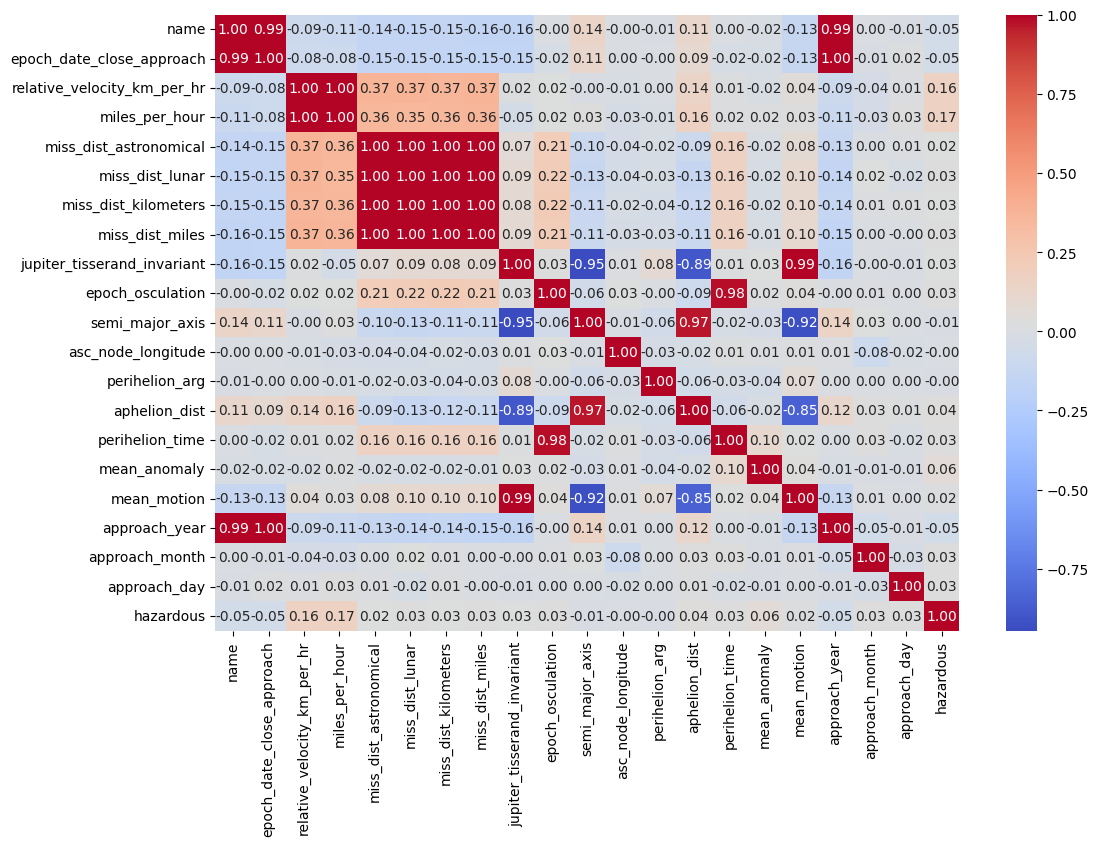

In [6]:
#now that i have train_data_num i am going find corelation matrix
print(train_data_num.corr())
plt.figure(figsize=(12,8))
sns.heatmap(train_data_num.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



form the above table we can see major trends in the data 
1. relative_velocity_km_per_hr and miles_per_hour are perfectly correlated with each other (1.00)
2. All four miss_dist_ columns (astronomical, lunar, kilometers, miles) are perfectly correlated with each other (1.00)
3. jupiter_tisserand_invariant has a very strong negative correlation (~-0.95) with semi_major_axis and a strong positive correlation (~0.99) with mean_motion
4. relative_velocity_km_per_hr and miles_per_hour have the strongest correlation with hazardous (~0.16). It's a weak positive relationship, suggesting faster objects are slightly more likely to be flagged as hazardous.
5. miss_dist variables have low correlation with hazardous (~0.02 to 0.03), meaning how far away they miss Earth isn't strongly linearly related to the 'hazardous' flag itself.
6. asc_node_longitude and perihelion_arg are nearly uncorrelated with hazardous (near 0.00), suggesting these orbital parameters don't linearly affect the classification.


So from the above results i am going to drop some of the columns which are highly corelated.
- distance in different units astronomical, lunar, kilometers, miles i am only going to keep kilometers
- speed in different units relative_velocity_km_per_hr and miles_per_hour i am going to keep only relative_velocity_km_per_hr
- also i am going to drop approach_year,approach_month,approach_day and keep epoch_date_close_approach

Current columns: Index(['name', 'epoch_date_close_approach', 'relative_velocity_km_per_hr',
       'miles_per_hour', 'miss_dist_astronomical', 'miss_dist_lunar',
       'miss_dist_kilometers', 'miss_dist_miles',
       'jupiter_tisserand_invariant', 'epoch_osculation', 'semi_major_axis',
       'asc_node_longitude', 'perihelion_arg', 'aphelion_dist',
       'perihelion_time', 'mean_anomaly', 'mean_motion', 'approach_year',
       'approach_month', 'approach_day', 'hazardous'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4034 entries, 0 to 4033
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         4034 non-null   int64  
 1   epoch_date_close_approach    2916 non-null   float64
 2   relative_velocity_km_per_hr  2699 non-null   float64
 3   miles_per_hour               3275 non-null   float64
 4   miss_dist_kilometers         2815 no

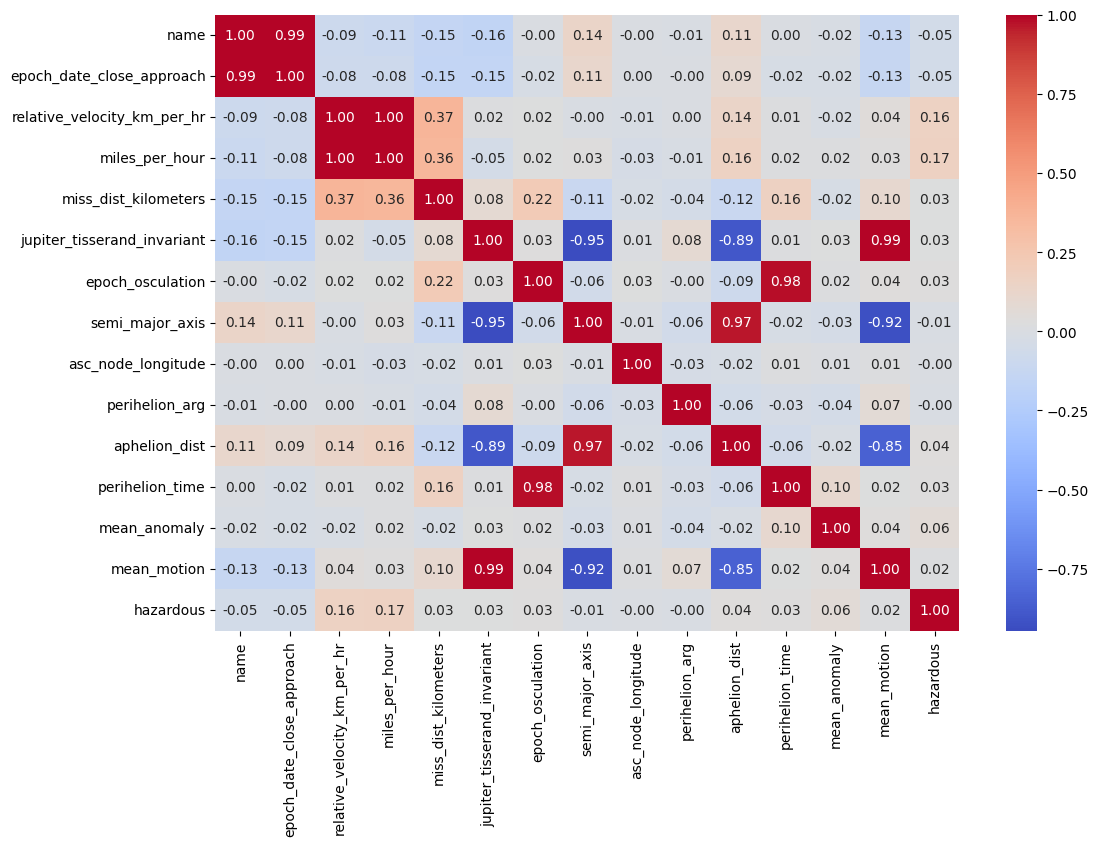

In [7]:
columns_to_drop_1 = ['approach_year', 'approach_month', 'approach_day','miss_dist_astronomical','miss_dist_lunar','miss_dist_miles']
print("Current columns:", train_data_num.columns)

train_data_f =  train_data_num.drop(columns = columns_to_drop_1)
print(train_data_f.info())
plt.figure(figsize=(12,8))
sns.heatmap(train_data_f.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [8]:
corr = train_data_f.corr()

strong_corr = (
    corr
    .where((np.abs(corr) > 0.8) & (np.abs(corr) < 1))
    .stack()
    .reset_index()
)

strong_corr.columns = ['feature_1', 'feature_2', 'correlation']

print(strong_corr)

                      feature_1                    feature_2  correlation
0                          name    epoch_date_close_approach     0.994147
1     epoch_date_close_approach                         name     0.994147
2   jupiter_tisserand_invariant              semi_major_axis    -0.945252
3   jupiter_tisserand_invariant                aphelion_dist    -0.893028
4   jupiter_tisserand_invariant                  mean_motion     0.992957
5              epoch_osculation              perihelion_time     0.981697
6               semi_major_axis  jupiter_tisserand_invariant    -0.945252
7               semi_major_axis                aphelion_dist     0.969105
8               semi_major_axis                  mean_motion    -0.923723
9                 aphelion_dist  jupiter_tisserand_invariant    -0.893028
10                aphelion_dist              semi_major_axis     0.969105
11                aphelion_dist                  mean_motion    -0.849028
12              perihelion_time       

In [9]:
# Check for class imbalance
print(train_data['hazardous'].value_counts())
print(train_data['hazardous'].value_counts(normalize=True)*100)

hazardous
0    3598
1     436
Name: count, dtype: int64
hazardous
0    89.191869
1    10.808131
Name: proportion, dtype: float64


this above result tells us that only 10.8% of the data is actually 1 and rest is 0. This is data imbalance.
to understand this i used these resources 

https://youtu.be/yh2AKoJCV3k?si=I6rd1f46vkHUv5p6

https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/

https://imbalanced-learn.org/

few methods discussed in the video are
1. Undersampling: doing random sampling from majority till data point in majority = minority. 
advantages: reduction in bias , faster training
disadvantages: information loss leading to underfitting , sampling bias
2. Oversampling: copies of the minority class
advantages: reduced bias
disadvantages: increased size , duplication of the data can cause overfitting
3. SMOTE: Synthetic Minority Oversampling Technique :SMOTE examines instances in the minority class, selects a random nearest neighbor using k-nearest neighbors, and generates a synthetic instance randomly within the feature space.
factor = random number between 0 and 1
new data point = original data point - factor * (original data point - neighbour)
disadvantages: 
- does not handel catagorical data well 
- computational complexity
- dependency on choice of neighbours
- sensitivity to outliers
- balance achived may not refelect true nature
4. Ensemble method 
balanced random forest 
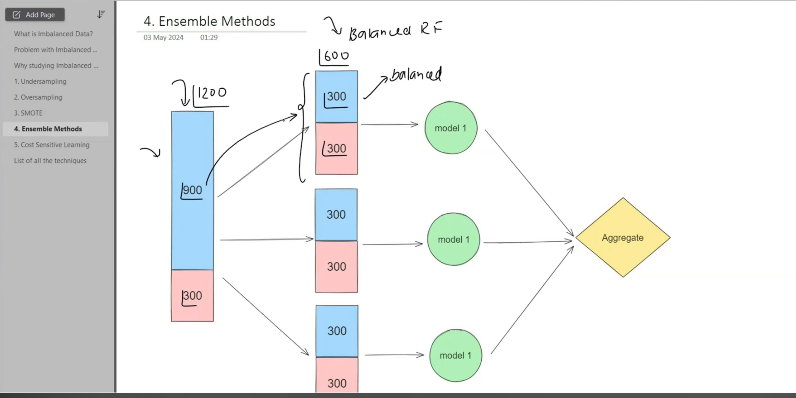
5. cost sensitive learning 
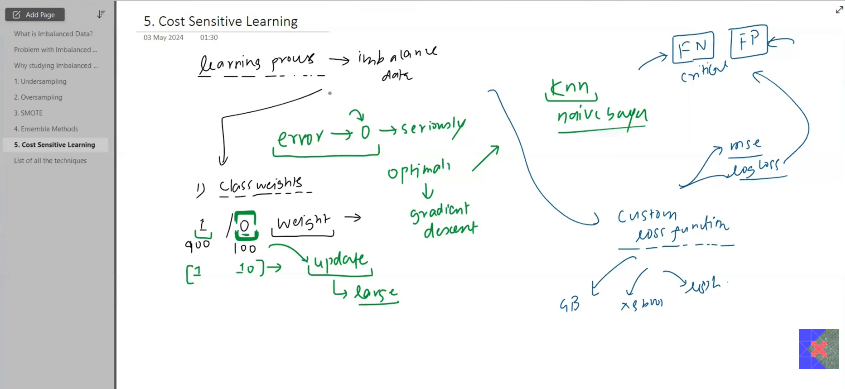


among above things i am planning to start with Ensemble
these are different methods 
1. EasyEnsemble
2. RUSBoost
3. BalancedBagging
4. Balanced RF

what i have idea in my mind is to treat them as hyperparameters and train them with optuna along with selection of required model.

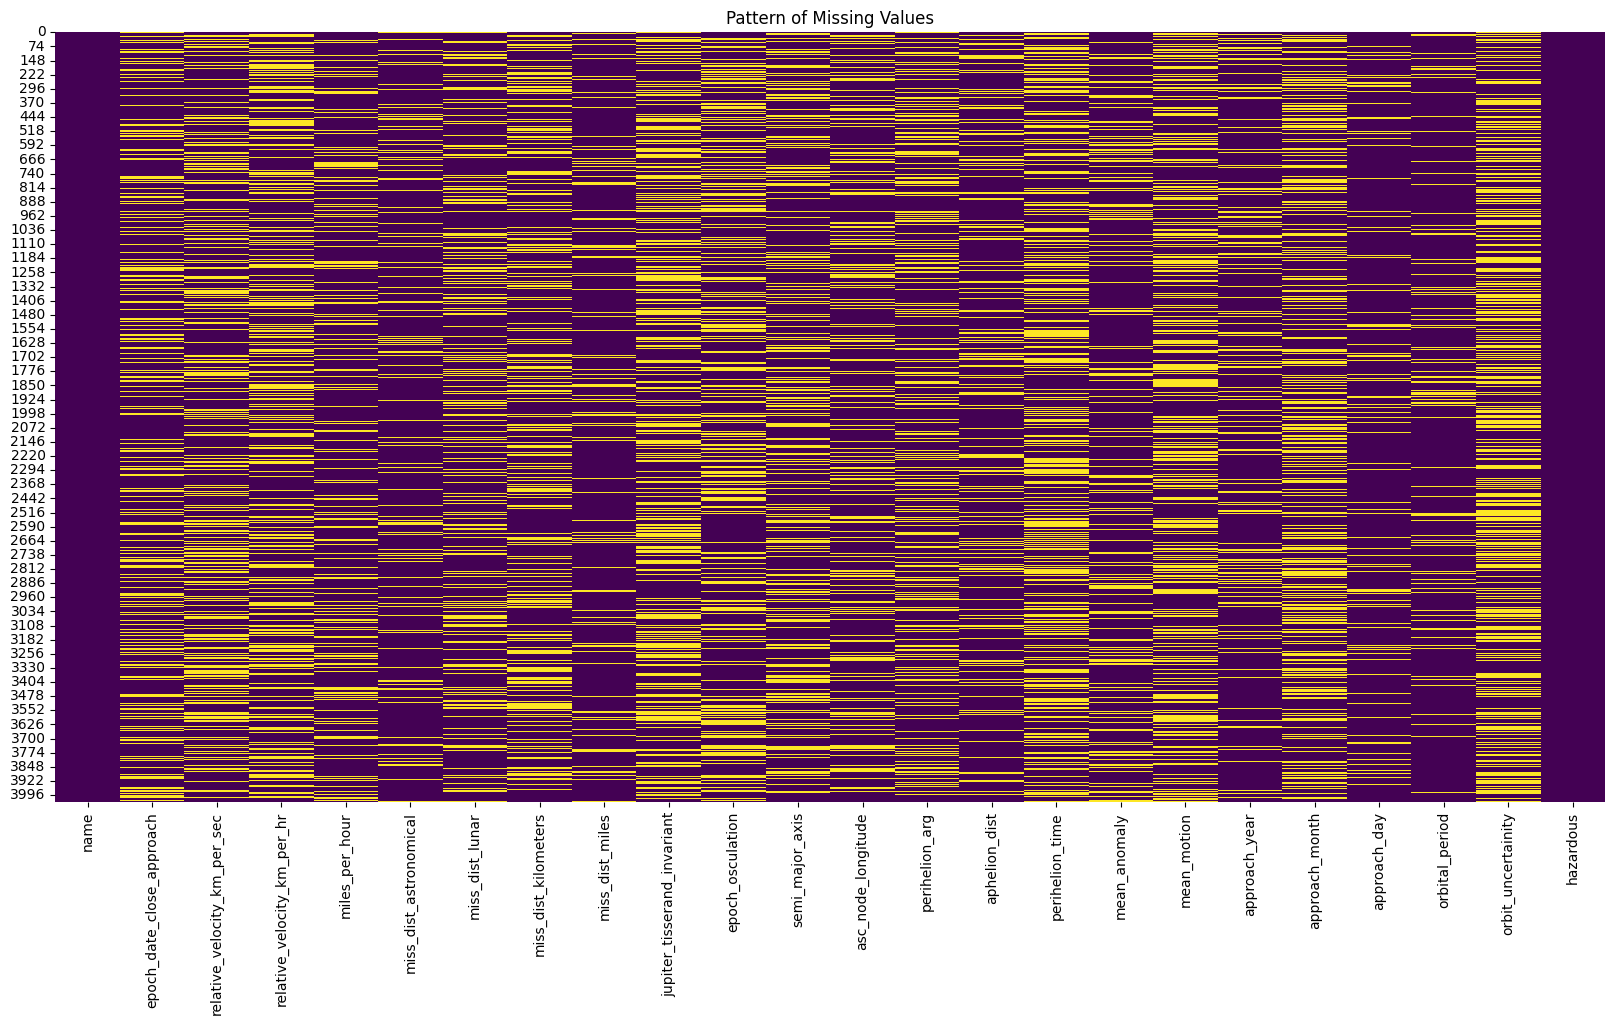

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Pattern of Missing Values")
plt.show()

now i am going to look into what to do of missing values in the data.
source: https://youtu.be/WPiYOS3qK70?si=jpQIj2dYXhj8KqOX
i am planning to use ***MICE*** (Multivariate Imputation By Chained Equations)
The data is classified in three catagories 
1. Missing completely at random (MCAR) : cant be explained
2. Missing at Random (MAR) : can be explained from other columns
3. Missing not at random (MNAR): there was a reason data is missing
for MICE we assume data is MCAR
for using this i have few options 
1. miceforest
2. Sklearn IterativeImputer
i am planning to use miceforest as it works well on complex models, handels catagorical data automatically. It trains a LightGBM using all other columns.
https://medium.com/@Sanjjushri/effortless-data-imputation-with-miceforest-in-python-53d1692db529

In [11]:
train_mice = train_data.copy()
for col in train_mice.select_dtypes(include=['object']).columns:
    train_mice[col] = train_mice[col].astype('category')

kds = mf.ImputationKernel(
    train_data_num,
    save_all_iterations_data=True,
    random_state=42,
)
kds.mice(iterations=5)
df_imputed_num = kds.complete_data()
print(df_imputed_num.isnull().sum())

name                           0
epoch_date_close_approach      0
relative_velocity_km_per_hr    0
miles_per_hour                 0
miss_dist_astronomical         0
miss_dist_lunar                0
miss_dist_kilometers           0
miss_dist_miles                0
jupiter_tisserand_invariant    0
epoch_osculation               0
semi_major_axis                0
asc_node_longitude             0
perihelion_arg                 0
aphelion_dist                  0
perihelion_time                0
mean_anomaly                   0
mean_motion                    0
approach_year                  0
approach_month                 0
approach_day                   0
hazardous                      0
dtype: int64


In [12]:
train_mice = train_data_obj.copy()
for col in train_mice.select_dtypes(include=['object']).columns:
    train_mice[col] = train_mice[col].astype('category')

kds = mf.ImputationKernel(
    train_mice,
    save_all_iterations_data=True,
    random_state=42,
)
kds.mice(iterations=5)
df_imputed_catg = kds.complete_data()
print(df_imputed_catg.isnull().sum())

relative_velocity_km_per_sec    0
orbital_period                  0
orbit_uncertainity              0
dtype: int64


as of now we filled the missing data with mice but this may be wrong as this hasent yet know physics and may train our model for impossible physics 

In [13]:
skewness_vals = df_imputed_num.skew().sort_values(ascending=False)

# Flag features that need transformation (> 0.5 or < -0.5)
transform_needed = skewness_vals
print("Features requiring log transformation:")
print(transform_needed)

Features requiring log transformation:
hazardous                      2.525513
aphelion_dist                  1.127797
relative_velocity_km_per_hr    0.913186
miles_per_hour                 0.904585
semi_major_axis                0.873093
mean_motion                    0.392833
jupiter_tisserand_invariant    0.113809
asc_node_longitude             0.061151
approach_day                   0.002330
name                          -0.020081
approach_month                -0.048365
mean_anomaly                  -0.059235
perihelion_arg                -0.062732
miss_dist_lunar               -0.090134
miss_dist_astronomical        -0.090558
miss_dist_miles               -0.091083
miss_dist_kilometers          -0.091197
approach_year                 -0.299822
epoch_date_close_approach     -0.307701
perihelion_time               -3.723265
epoch_osculation              -3.916016
dtype: float64


In [14]:
counts = df_imputed_catg.value_counts()
print(counts)

relative_velocity_km_per_sec  orbital_period  orbit_uncertainity
Slow                          Low             Low                   618
Very Slow                     Low             Low                   444
                                              Medium                360
                                              High                  345
Slow                          Low             Medium                294
                                              High                  238
Very Slow                     Medium          Low                   179
Slow                          Medium          Low                   174
Fast                          Low             Low                   163
Slow                          Medium          Medium                120
Very Slow                     Medium          High                  113
Slow                          Medium          High                  103
                              High            High                   99

damn the data is fucked real bad

as of now we have understood the data is skwed 
for this i need to do some kind of transformations on the data.
for this i am using this resources https://youtu.be/cTjj3LE8E90?si=rZP9didBNV1rrvPT
https://youtu.be/lV_Z4HbNAx0?si=BGzbjPGx07INoiaj
sklearn has
- Function Transformer
- Power Transformer
- Quantile Transformer
Also one more thing is i think it is fine if we dont do this transformations as i am planning to use something related to tree and not some models which care a lot about distribution and want a normal distribution.
models which care a lot about data distribution:
- Linear & Statistical models: eg Linear Regression,Logistic Regression,LDA / QDA,Naive Bayes
- Distance-based models: KNN,K-means,DBSCAN,SVM
- Probabilistic / Density models: Gaussian Mixture Models (GMM), Hidden Markov Models,Bayesian models


to know we can use 
1. sns.distplot
2. pd.skew
3. QQplot (most reliable)
#### Popular Function Transformer
1. Log Transform: we just take log of the data. doesnt work on -ve values. best for Right-skewed, log-normal, or exponential data distributions
2. Reciprocal Transform: just take inverse
3. Square Transform: just take square. mostly used on left skewed
4. Square Root Transform: just take square
#### Popular Power Transformer
1. Box-Cox: The exponent here is a variable called lambda that varies over range 0f -5 to +5 and in the process of searching we examine all values of lambda. finally we choose best value.
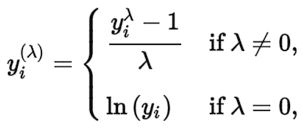
2. Yeo-Johnson: somewhat adjusment to the box-cox transformation by which we can use it on -ve nums
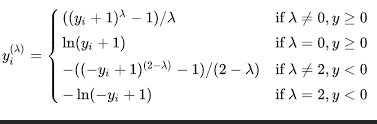

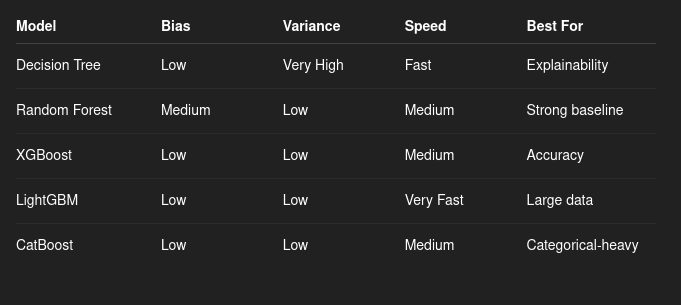